In [6]:
pip install meteostat

In [7]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from google.colab import files

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
scaler = joblib.load('/content/drive/MyDrive/ML Collab/long_term_scaler.pkl')
print("Scaler loaded \n\n")

df = pd.read_csv('/content/drive/MyDrive/ML Collab/long_term_consumption.csv')
df.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
df = df.dropna()

df.head()

Scaler loaded 




,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,wdir,wspd,pres,Month,Day,Day_of_week,previousDay,previous2Day,previous3Day,previous4Day,previous5Day,previous6Day,previous7Day
7,2006-12-27,25.479333,0.161491,0.261589,0.061828,0.000000,0.588889,0.226131,0.851504,12,27,2,0.813321,0.755767,0.693574,0.507384,0.659123,0.492354,0.652590
8,2006-12-28,34.543967,0.121118,0.172185,0.064516,0.000000,0.463889,0.296482,0.800752,12,28,3,0.451393,0.813321,0.755767,0.693574,0.507384,0.659123,0.492354
9,2006-12-29,52.906533,0.217391,0.158940,0.231183,0.000000,0.463889,0.442211,0.689850,12,29,4,0.613490,0.451393,0.813321,0.755767,0.693574,0.507384,0.659123
10,2007-01-01,45.816733,0.459627,0.460265,0.427419,0.518248,0.641667,0.894472,0.607143,1,1,0,0.941857,0.613490,0.451393,0.813321,0.755767,0.693574,0.507384
11,2007-01-02,21.153933,0.369565,0.437086,0.271505,0.262774,0.752778,0.638191,0.727444,1,2,1,0.815074,0.941857,0.613490,0.451393,0.813321,0.755767,0.693574


In [10]:
feature_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
       'pres', 'Month', 'Day', 'Day_of_week',
      'previousDay', 'previous2Day','previous3Day','previous4Day','previous5Day','previous6Day','previous7Day']

scaler_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
       'pres', 'previousDay', 'previous2Day',
       'previous3Day','previous4Day','previous5Day','previous6Day','previous7Day']

X = df[feature_columns]
y = df['Daily_Energy_kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

sgd_model = SGDRegressor(random_state=42, warm_start=True)

param_grid = {
    'alpha': [0.01],
    'eta0': [0.001],
    'penalty': ['l1'],
    'l1_ratio': [0.15],
    'max_iter': [5000],
    'tol': [1e-6],
    'learning_rate': ['adaptive'],
    'power_t': [0.25]
}



grid_search = GridSearchCV(sgd_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Parameters from GridSearchCV:", grid_search.best_params_)


Best Parameters from GridSearchCV: {'alpha': 0.01, 'eta0': 0.001, 'l1_ratio': 0.15, 'learning_rate': 'adaptive', 'max_iter': 5000, 'penalty': 'l1', 'power_t': 0.25, 'tol': 1e-06}


In [11]:
batch_size = 2000
n_batches = len(X_train) // batch_size

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    X_batch = X_train.iloc[start_idx:end_idx]
    y_batch = y_train.iloc[start_idx:end_idx]

    X_batch = X_batch[feature_columns]

    best_model.partial_fit(X_batch[feature_columns], y_batch) # ensure all features are used in training
    print(f"Batch {i+1}/{n_batches} fitted")


predictions = best_model.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("R² Score:", r2)
print("MSE:", mse)
print("MAE:", mae)

print()

R² Score: 0.43041114456831653
MSE: 46.68168491892012
MAE: 5.2970270081131545



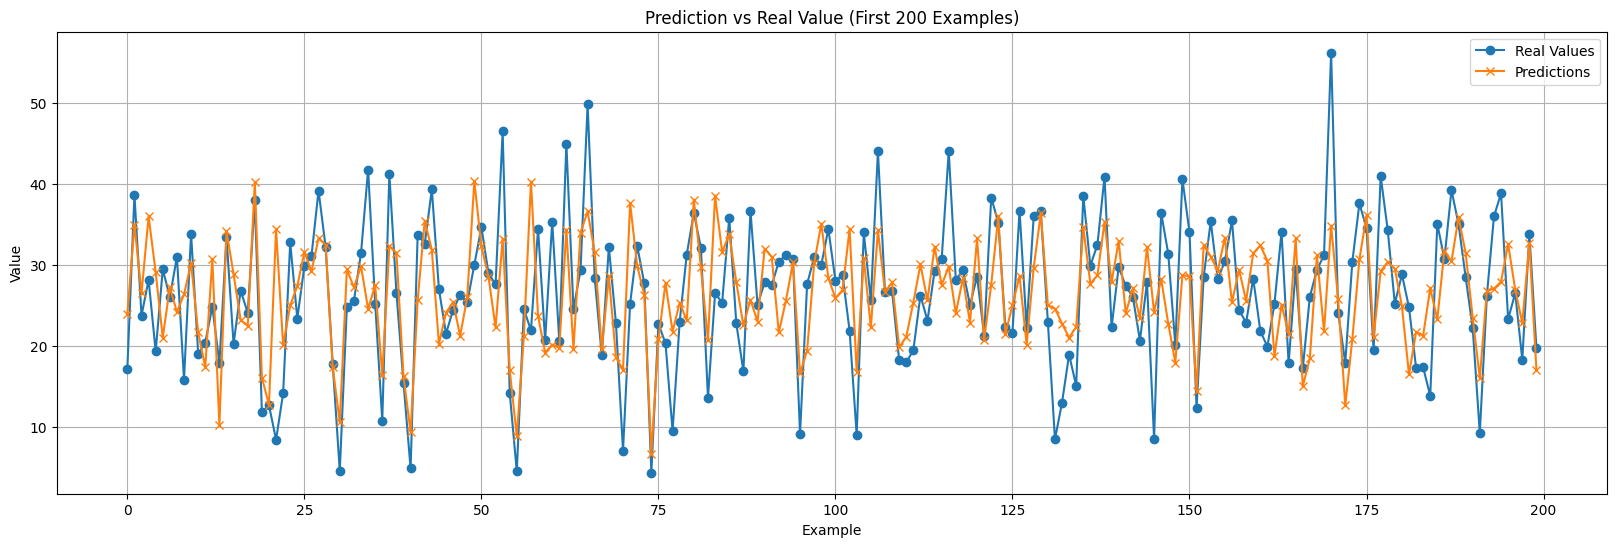

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test' are already defined from your previous code
# Plot only the first 200 examples
plt.figure(figsize=(20, 6))
plt.plot(range(200), y_test[:200], label='Real Values', marker='o')
plt.plot(range(200), predictions[:200], label='Predictions', marker='x')
plt.xlabel('Example')
plt.ylabel('Value')
plt.title('Prediction vs Real Value (First 200 Examples)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# prompt: Save the model to drive
import joblib

# Save the trained model to your Google Drive
joblib.dump(best_model, '/content/drive/MyDrive/ML Collab/sgd_model.pkl')
print("Model saved to Google Drive")


Model saved to Google Drive
